<a href="https://colab.research.google.com/github/gayecolakoglu/DiabeticRetinopathyDetection/blob/main/Bayesian_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pathlib
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [2]:
#https://medium.com/@pierre.beaujuge/bayesian-optimization-on-the-head-classifier-of-pre-trained-cnns-using-the-cifar10-dataset-48c440b67b2c
# Install GPy, GPyOpt
!pip install GPy==1.9.8
!pip install GPyOpt==1.2.1
import tensorflow as tf
import tensorflow.keras as K
import numpy as np
import skimage.io
import matplotlib.pyplot as plt
%matplotlib inline
import GPy
import GPyOpt
from GPyOpt.methods import BayesianOptimization

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 989 kB 4.2 MB/s 
     |████████████████████████████████| 71 kB 3.8 MB/s 
  Created wheel for GPy: filename=GPy-1.9.8-cp37-cp37m-linux_x86_64.whl size=2619378 sha256=bfd8b2e1893d53afce7cdad6686b466b73b7221c61046e957fa38311edd4c9ac
  Stored in directory: /root/.cache/pip/wheels/23/6d/58/90d8e44f8fd9f442de81992a427a5947a6e5f7b78cd65acd9a
  Created wheel for paramz: filename=paramz-0.9.5-py3-none-any.whl size=102566 sha256=c1030485b349994b12c6b5c982579cc6f00c79b7522a14d78116c806856efd42
  Stored in directory: /root/.cache/pip/wheels/c8/95/f5/ce28482da28162e6028c4b3a32c41d147395825b3cd62bc810
Successfully built GPy paramz
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 46 kB 1.9 MB/s 
  Created wheel for GPyOpt: filename=GPyOpt-1.2.1-py3-none-any.whl size=73656 sha

In [3]:
!pip install split-folders
import splitfolders
splitfolders.ratio('/content/gdrive/MyDrive/KaggleImageData/UfukHocaVeri', output="output", seed=1337, ratio=(.7, 0.2,0.1)) #train,val,test

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Copying files: 193 files [00:48,  3.96 files/s]


In [4]:
#https://stackoverflow.com/questions/55674648/how-to-load-local-dataset-x-y-using-keras-framework
!pip install image-dataset-loader
from image_dataset_loader import load

(x_train, y_train), (x_test, y_test) = load('/content/output/', ['train', 'val']) # Görselleri dataframe'e yazar target'la birlikte. Görselleri array olarak tutar.

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
# Görselleri normalize eder (x = x / 255) targetlara da one hot encoding yapar (1,0,0)
def preprocess_data(X, Y):
    """
    function that pre-processes the DR dataset as per
    densenet model requirements for input images
    labels are one-hot encoded
    """
    X = tf.keras.applications.vgg16.preprocess_input(X)
    Y = K.utils.to_categorical(Y)
    return X, Y

In [6]:
# preprocess the data using the application's preprocess_input method and convert the labels to one-hot encodings
x_train, y_train = preprocess_data(x_train, y_train)
x_test, y_test = preprocess_data(x_test, y_test)

In [7]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Input
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import Dense,Flatten,Conv2D,Activation,Dropout

input_tensor = K.Input(shape=(32, 32, 3)) # Input olarak girecek yapıyı oluşturur
# resize images to the image size upon which the network was pre-trained
resized_images = K.layers.Lambda(lambda image: tf.image.resize(image, (224, 224)))(input_tensor) # lambda list comp. gibi input_tensordaki tüm image'ı resize ediyor
base_model = VGG16(include_top=False,
                    weights='imagenet',
                    input_tensor=resized_images,
                    input_shape=(224, 224, 3),
                    pooling='max')

output = base_model.layers[-1].output # Denenecek
base_model = K.models.Model(inputs=input_tensor, outputs=output) # No idea

58900480/58889256 [==============================] - 0s 0us/step


In [8]:
# using the training data
train_datagen = K.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                        rotation_range=40,
                                                        width_shift_range=0.2,
                                                        height_shift_range=0.2,
                                                        zoom_range=0.2,
                                                        shear_range=0.2,
                                                        horizontal_flip=True,
                                                        fill_mode='nearest')# with data augmentation for train set
      
train_generator = train_datagen.flow(x_train,
                                     y_train,
                                     batch_size=32,
                                     shuffle=False)
features_train = base_model.predict(train_generator)
# repeat the same operation with the test data (here used for validation)
val_datagen = K.preprocessing.image.ImageDataGenerator(rescale=1./255)  # no augmentation for validation set
val_generator = val_datagen.flow(x_test,
                                 y_test,
                                 batch_size=32,
                                 shuffle=False)
features_valid = base_model.predict(val_generator)

In [9]:
from tensorflow.keras import layers, models
from keras.models import Sequential, Model

def build_model(units=256, learning_rate=1e-4, l2=1e-2, activation=2, rate=0.5, batch = 32):
  """function that builds a model for the head classifier"""
  # weights are initialized as per the he et al. method
  initializer = K.initializers.he_normal()
  input_tensor = K.Input(shape=features_train.shape[1])
  activation_dict = {1: 'relu', 2: 'elu', 3: 'tanh'}
  layer = K.layers.Dense(units=units,
                         activation=activation_dict[activation],
                         kernel_initializer=initializer,
                        kernel_regularizer=K.regularizers.l2(l2=l2))
  output = layer(input_tensor)
  dropout = K.layers.Dropout(rate)
  output = dropout(output)
  softmax = K.layers.Dense(units=5,
                           activation='softmax',
                           kernel_initializer=initializer,
                        kernel_regularizer=K.regularizers.l2(l2=l2))
  output = softmax(output)
  model = K.models.Model(inputs=input_tensor, outputs=output)
  # compile the densely-connected head classifier (here, "model")
  model.compile(
           optimizer=K.optimizers.Adam(learning_rate=learning_rate),
           loss='categorical_crossentropy',
           metrics=['accuracy'])
  # Define some callback functions to be used by the model during training
  # reduce learning rate when val_accuracy has stopped improving
  lr_reduce = K.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                            factor=0.6,
                                            patience=2,
                                            verbose=1,
                                            mode='max',
                                            min_lr=1e-7)
  # stop training when val_accuracy has stopped improving
  early_stop = K.callbacks.EarlyStopping(monitor='val_accuracy',
                                         patience=3,
                                         verbose=1,
                                         mode='max')
  # callback to save the Keras model and (best) weights obtained on an epoch basis
  checkpoint = K.callbacks.ModelCheckpoint('VGG_16.h5',
                                           monitor='val_accuracy',
                                           verbose=1,
                                           save_weights_only=False,
                                           save_best_only=True,
                                           mode='max',
                                           save_freq='epoch')
  return model, lr_reduce, early_stop, checkpoint, batch

In [10]:
def fit_model(model, lr_reduce, early_stop, checkpoint, batch):
  """function that trains the head classifier"""
  history = model.fit(features_train, y_train,
                      batch_size=batch,
                      epochs=200,
                      verbose=0,
                      callbacks=[lr_reduce, early_stop, checkpoint],
                      validation_data=(features_valid, y_test),
                      shuffle=True)
  return history

In [11]:
def evaluate_model(model):
  """function that evaluates the head classifier"""
  evaluation = model.evaluate(features_valid, y_test)
  return evaluation


Hyperparameters: [[2.56e+02 1.00e-05 1.00e-01 1.00e+00 3.00e-01 2.56e+02]]

Epoch 1: val_accuracy improved from -inf to 0.13514, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.13514

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 3: val_accuracy did not improve from 0.13514

Epoch 4: val_accuracy did not improve from 0.13514
Epoch 4: early stopping
2/2 [==============================] - 0s 8ms/step - loss: 54.5037 - accuracy: 0.1351

LOSS:	54.50367736816406 	 ACCURACY:	0.13513512909412384
[54.50367736816406, 0.13513512909412384]



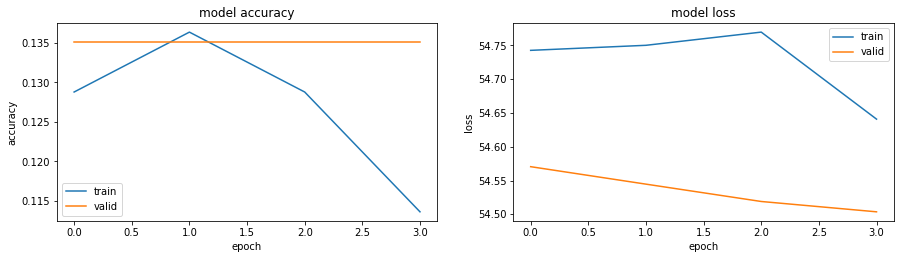


Hyperparameters: [[6.40e+01 1.00e-03 1.00e-03 3.00e+00 7.00e-01 2.56e+02]]
2/2 [==============================] - 0s 8ms/step - loss: 54.5037 - accuracy: 0.1351

Epoch 1: val_accuracy improved from -inf to 0.37838, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.37838 to 0.40541, saving model to VGG_16.h5

Epoch 3: val_accuracy did not improve from 0.40541

Epoch 4: val_accuracy improved from 0.40541 to 0.45946, saving model to VGG_16.h5

Epoch 5: val_accuracy did not improve from 0.45946

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 6: val_accuracy did not improve from 0.45946

Epoch 7: val_accuracy improved from 0.45946 to 0.48649, saving model to VGG_16.h5

Epoch 8: val_accuracy did not improve from 0.48649

Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0003600000170990825.

Epoch 9: val_accuracy did not improve from 0.48649

Epoch 10: val_accuracy did not improve from 0.48649
Epoch 10: early stopping
2/2 [============

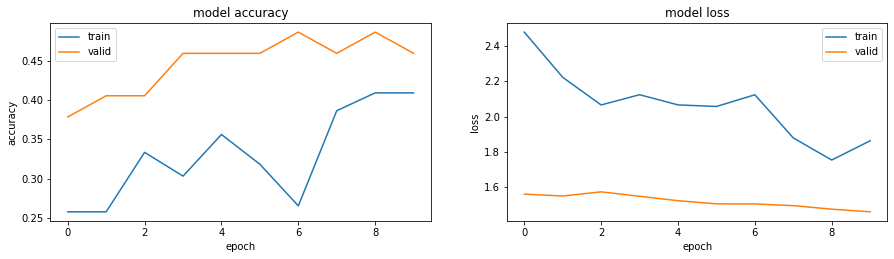


Hyperparameters: [[1.28e+02 1.00e-06 1.00e-03 2.00e+00 7.00e-01 3.20e+01]]
2/2 [==============================] - 0s 8ms/step - loss: 1.4616 - accuracy: 0.4595

Epoch 1: val_accuracy improved from -inf to 0.13514, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.13514

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 3: val_accuracy did not improve from 0.13514

Epoch 4: val_accuracy did not improve from 0.13514
Epoch 4: early stopping
2/2 [==============================] - 0s 12ms/step - loss: 2.4715 - accuracy: 0.1351

LOSS:	2.471479654312134 	 ACCURACY:	0.13513512909412384
[2.471479654312134, 0.13513512909412384]



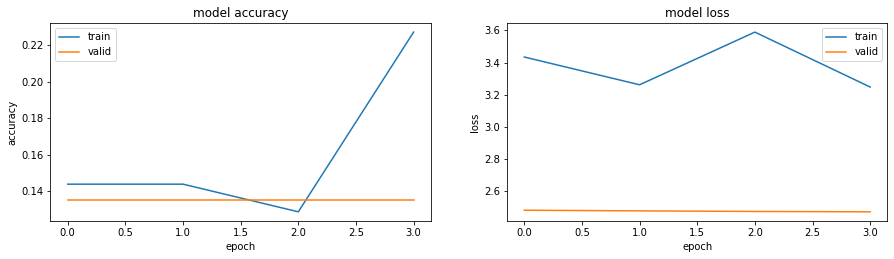


Hyperparameters: [[1.28e+02 1.00e-03 1.00e-03 2.00e+00 3.00e-01 2.56e+02]]
2/2 [==============================] - 0s 9ms/step - loss: 1.4616 - accuracy: 0.4595

Epoch 1: val_accuracy improved from -inf to 0.32432, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.32432 to 0.40541, saving model to VGG_16.h5

Epoch 3: val_accuracy did not improve from 0.40541

Epoch 4: val_accuracy improved from 0.40541 to 0.43243, saving model to VGG_16.h5

Epoch 5: val_accuracy improved from 0.43243 to 0.48649, saving model to VGG_16.h5

Epoch 6: val_accuracy did not improve from 0.48649

Epoch 7: val_accuracy improved from 0.48649 to 0.51351, saving model to VGG_16.h5

Epoch 8: val_accuracy did not improve from 0.51351

Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 9: val_accuracy did not improve from 0.51351

Epoch 10: val_accuracy did not improve from 0.51351
Epoch 10: early stopping
2/2 [==============================] - 0s 6ms/step - loss: 1.518

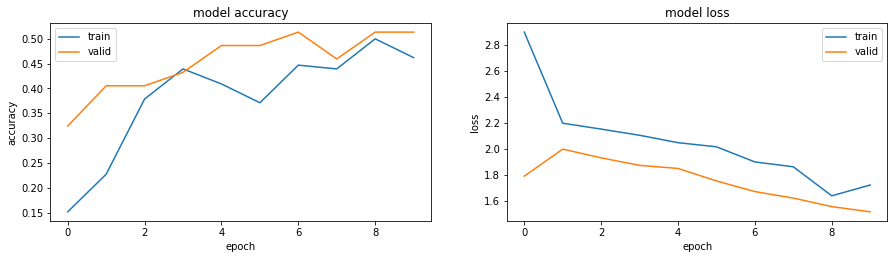


Hyperparameters: [[1.28e+02 1.00e-04 1.00e-01 3.00e+00 5.00e-01 1.28e+02]]
2/2 [==============================] - 0s 9ms/step - loss: 1.5187 - accuracy: 0.5135

Epoch 1: val_accuracy improved from -inf to 0.21622, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.21622

Epoch 3: val_accuracy improved from 0.21622 to 0.24324, saving model to VGG_16.h5

Epoch 4: val_accuracy improved from 0.24324 to 0.27027, saving model to VGG_16.h5

Epoch 5: val_accuracy improved from 0.27027 to 0.32432, saving model to VGG_16.h5

Epoch 6: val_accuracy did not improve from 0.32432

Epoch 7: val_accuracy improved from 0.32432 to 0.37838, saving model to VGG_16.h5

Epoch 8: val_accuracy did not improve from 0.37838

Epoch 9: val_accuracy improved from 0.37838 to 0.40541, saving model to VGG_16.h5

Epoch 10: val_accuracy did not improve from 0.40541

Epoch 11: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 11: val_accuracy did not improve from 0.40541

Epo

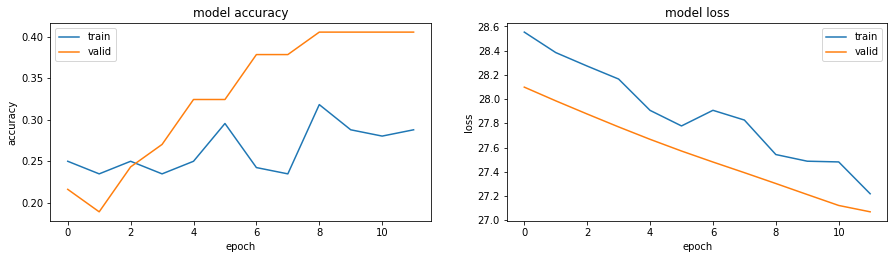




Hyperparameters: [[6.4e+01 1.0e-06 1.0e-02 3.0e+00 3.0e-01 3.2e+01]]
2/2 [==============================] - 0s 12ms/step - loss: 1.5187 - accuracy: 0.5135

Epoch 1: val_accuracy improved from -inf to 0.40541, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.40541

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 3: val_accuracy did not improve from 0.40541

Epoch 4: val_accuracy did not improve from 0.40541
Epoch 4: early stopping
2/2 [==============================] - 0s 5ms/step - loss: 2.8322 - accuracy: 0.4054

LOSS:	2.832225799560547 	 ACCURACY:	0.4054054021835327
[2.832225799560547, 0.4054054021835327]



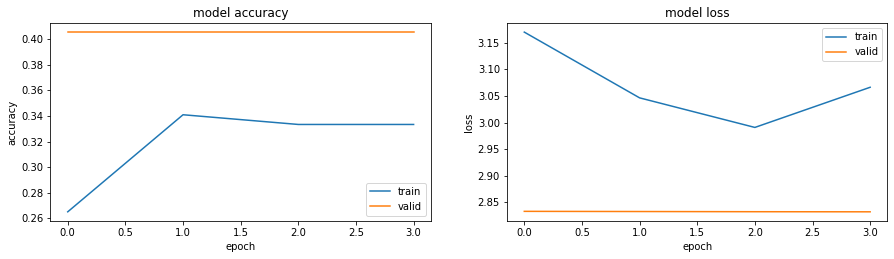


Hyperparameters: [[6.40e+01 1.00e-03 1.00e-01 1.00e+00 5.00e-01 1.28e+02]]
2/2 [==============================] - 0s 8ms/step - loss: 1.5187 - accuracy: 0.5135

Epoch 1: val_accuracy improved from -inf to 0.10811, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.10811 to 0.40541, saving model to VGG_16.h5

Epoch 3: val_accuracy did not improve from 0.40541

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 4: val_accuracy did not improve from 0.40541

Epoch 5: val_accuracy did not improve from 0.40541
Epoch 5: early stopping
2/2 [==============================] - 0s 5ms/step - loss: 13.2254 - accuracy: 0.2703

LOSS:	13.225381851196289 	 ACCURACY:	0.2702702581882477
[13.225381851196289, 0.2702702581882477]



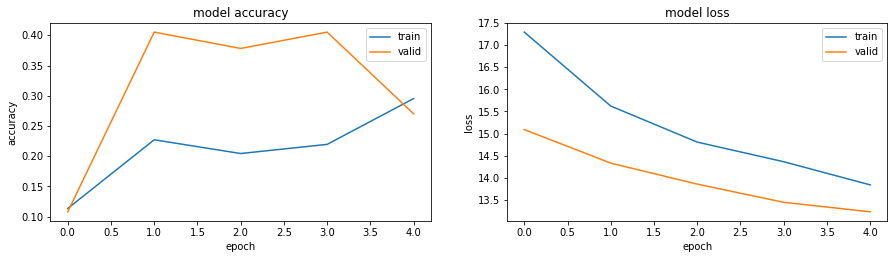


Hyperparameters: [[6.40e+01 1.00e-05 1.00e-03 2.00e+00 5.00e-01 2.56e+02]]
2/2 [==============================] - 0s 8ms/step - loss: 1.5187 - accuracy: 0.5135

Epoch 1: val_accuracy improved from -inf to 0.24324, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.24324

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 3: val_accuracy did not improve from 0.24324

Epoch 4: val_accuracy did not improve from 0.24324
Epoch 4: early stopping
2/2 [==============================] - 0s 9ms/step - loss: 2.5251 - accuracy: 0.2432

LOSS:	2.5250649452209473 	 ACCURACY:	0.2432432472705841
[2.5250649452209473, 0.2432432472705841]



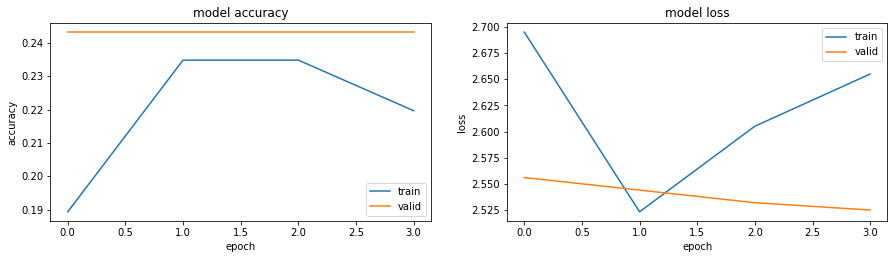


Hyperparameters: [[1.28e+02 1.00e-06 1.00e-02 3.00e+00 5.00e-01 3.20e+01]]
2/2 [==============================] - 0s 5ms/step - loss: 1.5187 - accuracy: 0.5135

Epoch 1: val_accuracy improved from -inf to 0.13514, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.13514

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 3: val_accuracy did not improve from 0.13514

Epoch 4: val_accuracy did not improve from 0.13514
Epoch 4: early stopping
2/2 [==============================] - 0s 6ms/step - loss: 4.6425 - accuracy: 0.1351

LOSS:	4.642514228820801 	 ACCURACY:	0.13513512909412384
[4.642514228820801, 0.13513512909412384]



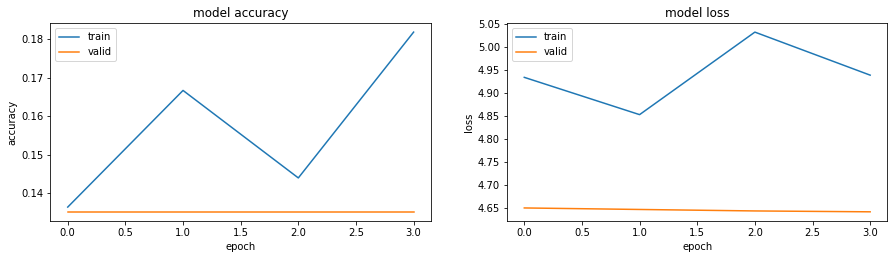


Hyperparameters: [[6.40e+01 1.00e-05 1.00e-03 3.00e+00 7.00e-01 1.28e+02]]
2/2 [==============================] - 1s 15ms/step - loss: 1.5187 - accuracy: 0.5135

Epoch 1: val_accuracy improved from -inf to 0.13514, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.13514

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 3: val_accuracy did not improve from 0.13514

Epoch 4: val_accuracy did not improve from 0.13514
Epoch 4: early stopping
2/2 [==============================] - 0s 7ms/step - loss: 2.6266 - accuracy: 0.1351

LOSS:	2.626645803451538 	 ACCURACY:	0.13513512909412384
[2.626645803451538, 0.13513512909412384]



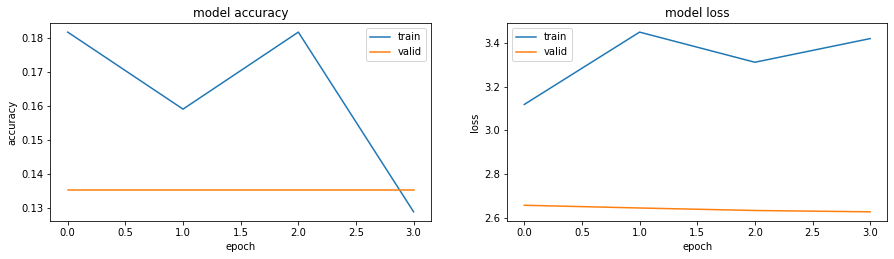


Hyperparameters: [[6.4e+01 1.0e-04 1.0e-01 1.0e+00 5.0e-01 3.2e+01]]
2/2 [==============================] - 0s 8ms/step - loss: 1.5187 - accuracy: 0.5135

Epoch 1: val_accuracy improved from -inf to 0.24324, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.24324

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 3: val_accuracy did not improve from 0.24324

Epoch 4: val_accuracy did not improve from 0.24324
Epoch 4: early stopping
2/2 [==============================] - 0s 7ms/step - loss: 15.1721 - accuracy: 0.2432

LOSS:	15.172060012817383 	 ACCURACY:	0.2432432472705841
[15.172060012817383, 0.2432432472705841]



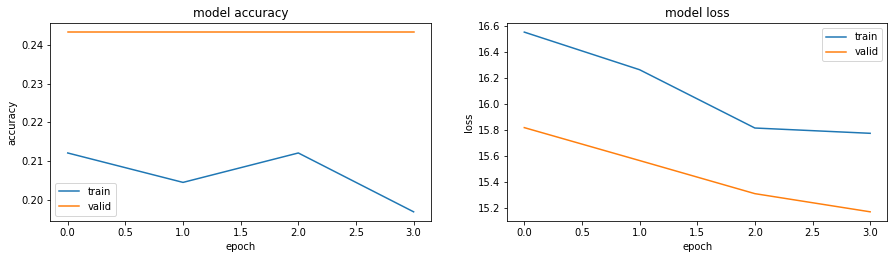


Hyperparameters: [[1.28e+02 1.00e-03 1.00e-03 1.00e+00 7.00e-01 3.20e+01]]
2/2 [==============================] - 0s 6ms/step - loss: 1.5187 - accuracy: 0.5135

Epoch 1: val_accuracy improved from -inf to 0.40541, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.40541 to 0.45946, saving model to VGG_16.h5

Epoch 3: val_accuracy did not improve from 0.45946

Epoch 4: val_accuracy improved from 0.45946 to 0.54054, saving model to VGG_16.h5

Epoch 5: val_accuracy did not improve from 0.54054

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 6: val_accuracy did not improve from 0.54054

Epoch 7: val_accuracy did not improve from 0.54054
Epoch 7: early stopping
2/2 [==============================] - 0s 5ms/step - loss: 1.5749 - accuracy: 0.5405

LOSS:	1.5748697519302368 	 ACCURACY:	0.5405405163764954
[1.5748697519302368, 0.5405405163764954]



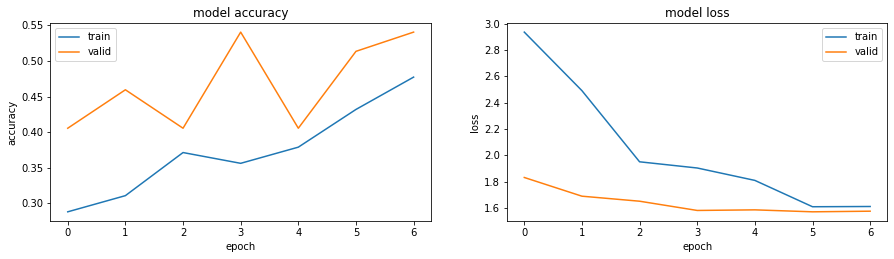


Hyperparameters: [[1.28e+02 1.00e-03 1.00e-02 2.00e+00 7.00e-01 2.56e+02]]
2/2 [==============================] - 0s 6ms/step - loss: 1.5749 - accuracy: 0.5405

Epoch 1: val_accuracy improved from -inf to 0.27027, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.27027 to 0.40541, saving model to VGG_16.h5

Epoch 3: val_accuracy did not improve from 0.40541

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 4: val_accuracy did not improve from 0.40541

Epoch 5: val_accuracy improved from 0.40541 to 0.45946, saving model to VGG_16.h5

Epoch 6: val_accuracy improved from 0.45946 to 0.48649, saving model to VGG_16.h5

Epoch 7: val_accuracy did not improve from 0.48649

Epoch 8: val_accuracy improved from 0.48649 to 0.51351, saving model to VGG_16.h5

Epoch 9: val_accuracy did not improve from 0.51351

Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0003600000170990825.

Epoch 10: val_accuracy did not improve from 0.51351

Epoch 11: 

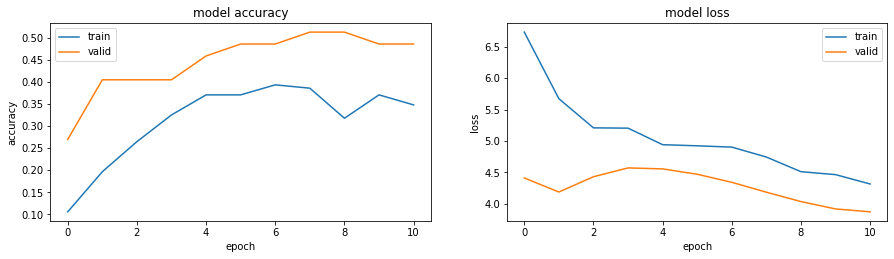


Hyperparameters: [[1.28e+02 1.00e-06 1.00e-01 2.00e+00 5.00e-01 1.28e+02]]
2/2 [==============================] - 0s 6ms/step - loss: 1.5749 - accuracy: 0.5405

Epoch 1: val_accuracy improved from -inf to 0.08108, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.08108

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 3: val_accuracy did not improve from 0.08108

Epoch 4: val_accuracy did not improve from 0.08108
Epoch 4: early stopping
2/2 [==============================] - 0s 6ms/step - loss: 30.9228 - accuracy: 0.0811

LOSS:	30.92278289794922 	 ACCURACY:	0.0810810774564743
[30.92278289794922, 0.0810810774564743]



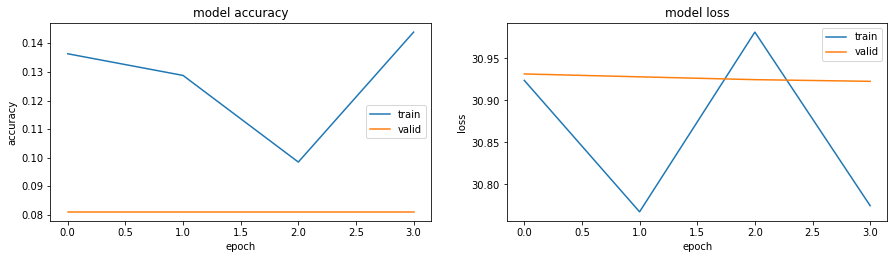


Hyperparameters: [[1.28e+02 1.00e-05 1.00e-02 2.00e+00 7.00e-01 3.20e+01]]
2/2 [==============================] - 0s 8ms/step - loss: 1.5749 - accuracy: 0.5405

Epoch 1: val_accuracy improved from -inf to 0.24324, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.24324

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 3: val_accuracy did not improve from 0.24324

Epoch 4: val_accuracy did not improve from 0.24324
Epoch 4: early stopping
2/2 [==============================] - 0s 6ms/step - loss: 4.3997 - accuracy: 0.1892

LOSS:	4.399702548980713 	 ACCURACY:	0.18918919563293457
[4.399702548980713, 0.18918919563293457]



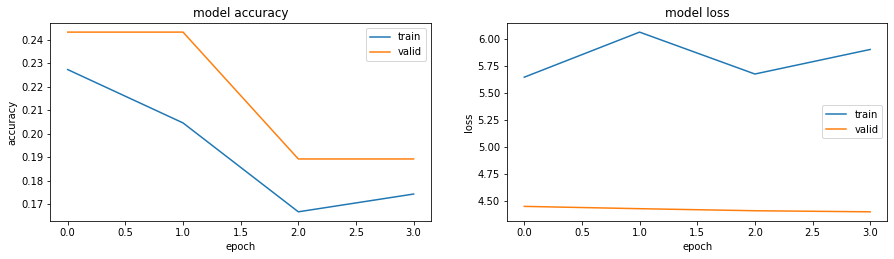


Hyperparameters: [[1.28e+02 1.00e-05 1.00e-03 1.00e+00 5.00e-01 3.20e+01]]
2/2 [==============================] - 0s 7ms/step - loss: 1.5749 - accuracy: 0.5405

Epoch 1: val_accuracy improved from -inf to 0.13514, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.13514

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 3: val_accuracy did not improve from 0.13514

Epoch 4: val_accuracy did not improve from 0.13514
Epoch 4: early stopping
2/2 [==============================] - 0s 7ms/step - loss: 3.0510 - accuracy: 0.1351

LOSS:	3.0510218143463135 	 ACCURACY:	0.13513512909412384
[3.0510218143463135, 0.13513512909412384]



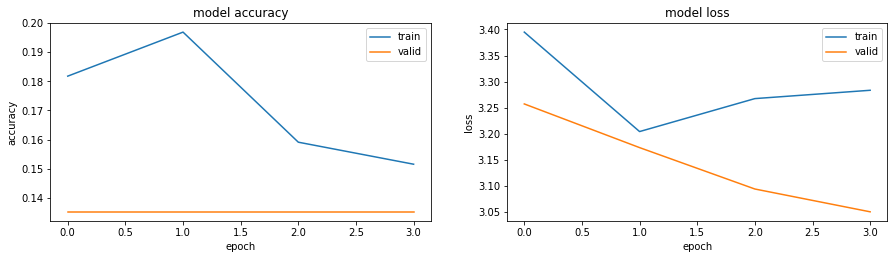


Hyperparameters: [[1.28e+02 1.00e-05 1.00e-02 2.00e+00 7.00e-01 1.28e+02]]
2/2 [==============================] - 0s 6ms/step - loss: 1.5749 - accuracy: 0.5405

Epoch 1: val_accuracy improved from -inf to 0.13514, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.13514

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 3: val_accuracy did not improve from 0.13514

Epoch 4: val_accuracy did not improve from 0.13514
Epoch 4: early stopping
2/2 [==============================] - 0s 4ms/step - loss: 4.7951 - accuracy: 0.1351

LOSS:	4.795059680938721 	 ACCURACY:	0.13513512909412384
[4.795059680938721, 0.13513512909412384]



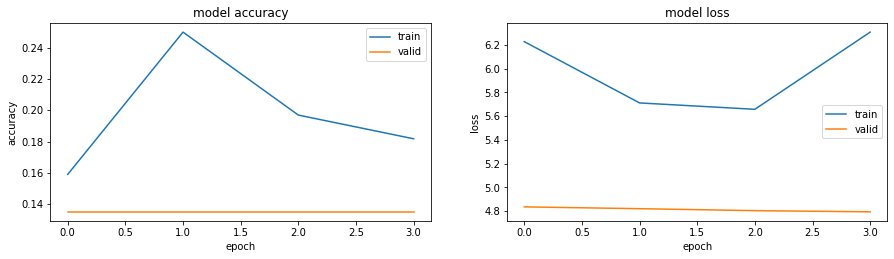


Hyperparameters: [[6.40e+01 1.00e-03 1.00e-03 2.00e+00 7.00e-01 1.28e+02]]
2/2 [==============================] - 0s 11ms/step - loss: 1.5749 - accuracy: 0.5405

Epoch 1: val_accuracy improved from -inf to 0.40541, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.40541

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 3: val_accuracy did not improve from 0.40541

Epoch 4: val_accuracy did not improve from 0.40541
Epoch 4: early stopping
2/2 [==============================] - 0s 6ms/step - loss: 2.1847 - accuracy: 0.4054

LOSS:	2.18471360206604 	 ACCURACY:	0.4054054021835327
[2.18471360206604, 0.4054054021835327]



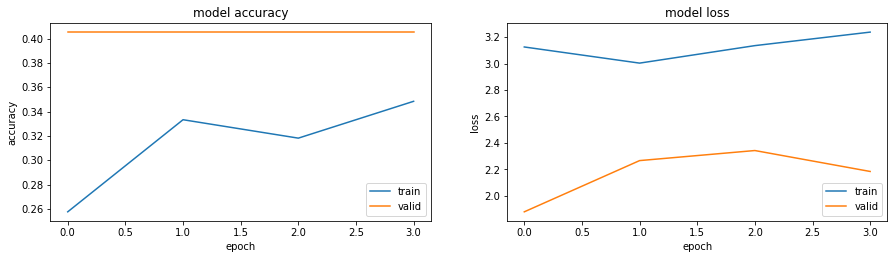


Hyperparameters: [[6.4e+01 1.0e-06 1.0e-02 3.0e+00 3.0e-01 3.2e+01]]
2/2 [==============================] - 0s 11ms/step - loss: 1.5749 - accuracy: 0.5405

Epoch 1: val_accuracy improved from -inf to 0.08108, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.08108

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 3: val_accuracy did not improve from 0.08108

Epoch 4: val_accuracy did not improve from 0.08108
Epoch 4: early stopping
2/2 [==============================] - 0s 9ms/step - loss: 3.9204 - accuracy: 0.0811

LOSS:	3.920375108718872 	 ACCURACY:	0.0810810774564743
[3.920375108718872, 0.0810810774564743]



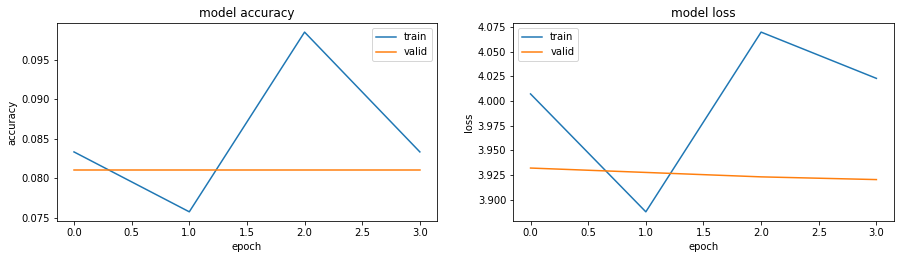


Hyperparameters: [[6.40e+01 1.00e-04 1.00e-01 3.00e+00 3.00e-01 2.56e+02]]
2/2 [==============================] - 0s 14ms/step - loss: 1.5749 - accuracy: 0.5405

Epoch 1: val_accuracy improved from -inf to 0.18919, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.18919 to 0.29730, saving model to VGG_16.h5

Epoch 3: val_accuracy did not improve from 0.29730

Epoch 4: val_accuracy improved from 0.29730 to 0.40541, saving model to VGG_16.h5

Epoch 5: val_accuracy improved from 0.40541 to 0.45946, saving model to VGG_16.h5

Epoch 6: val_accuracy did not improve from 0.45946

Epoch 7: val_accuracy improved from 0.45946 to 0.48649, saving model to VGG_16.h5

Epoch 8: val_accuracy did not improve from 0.48649

Epoch 9: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 9: val_accuracy did not improve from 0.48649

Epoch 10: val_accuracy did not improve from 0.48649
Epoch 10: early stopping
2/2 [==============================] - 0s 11ms/step - loss: 14.

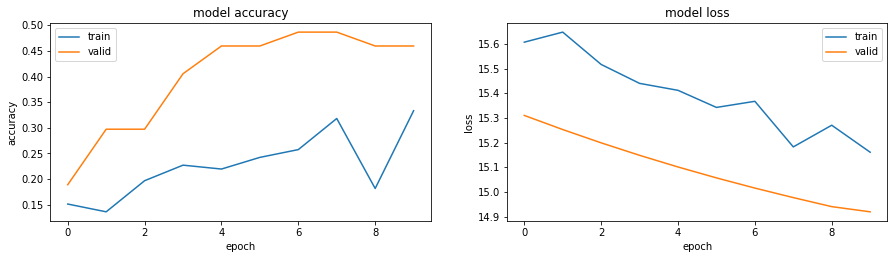


Hyperparameters: [[6.40e+01 1.00e-06 1.00e-01 1.00e+00 3.00e-01 1.28e+02]]
2/2 [==============================] - 0s 12ms/step - loss: 1.5749 - accuracy: 0.5405

Epoch 1: val_accuracy improved from -inf to 0.24324, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.24324

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 3: val_accuracy did not improve from 0.24324

Epoch 4: val_accuracy did not improve from 0.24324
Epoch 4: early stopping
2/2 [==============================] - 0s 9ms/step - loss: 15.9434 - accuracy: 0.2432

LOSS:	15.94344711303711 	 ACCURACY:	0.2432432472705841
[15.94344711303711, 0.2432432472705841]



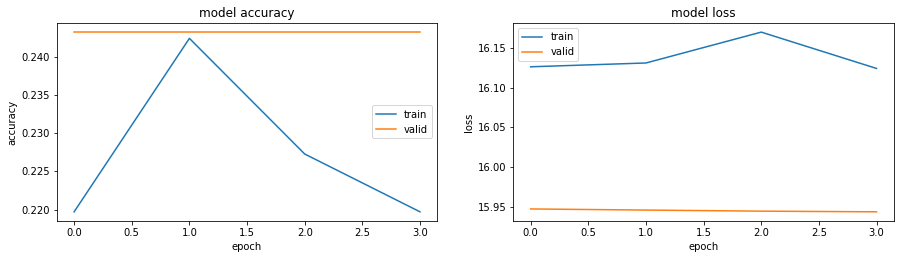


Hyperparameters: [[6.4e+01 1.0e-03 1.0e-03 1.0e+00 7.0e-01 3.2e+01]]
2/2 [==============================] - 0s 8ms/step - loss: 1.5749 - accuracy: 0.5405

Epoch 1: val_accuracy improved from -inf to 0.48649, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.48649

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 3: val_accuracy did not improve from 0.48649

Epoch 4: val_accuracy did not improve from 0.48649
Epoch 4: early stopping
2/2 [==============================] - 0s 12ms/step - loss: 1.5288 - accuracy: 0.4595

LOSS:	1.5288045406341553 	 ACCURACY:	0.45945945382118225
[1.5288045406341553, 0.45945945382118225]



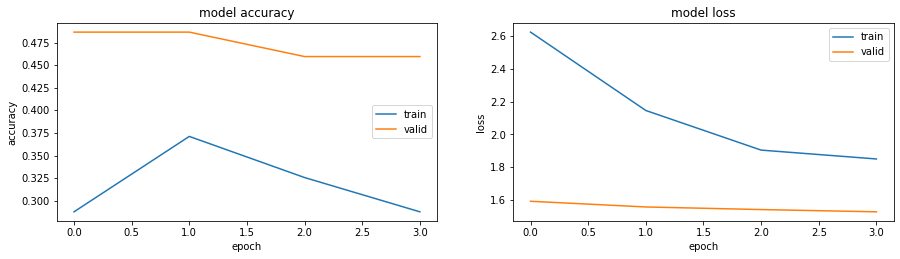


Hyperparameters: [[6.4e+01 1.0e-04 1.0e-02 2.0e+00 3.0e-01 3.2e+01]]
2/2 [==============================] - 0s 11ms/step - loss: 1.5749 - accuracy: 0.5405

Epoch 1: val_accuracy improved from -inf to 0.05405, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.05405 to 0.32432, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.32432 to 0.40541, saving model to VGG_16.h5

Epoch 4: val_accuracy improved from 0.40541 to 0.43243, saving model to VGG_16.h5

Epoch 5: val_accuracy did not improve from 0.43243

Epoch 6: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 6: val_accuracy did not improve from 0.43243

Epoch 7: val_accuracy did not improve from 0.43243
Epoch 7: early stopping
2/2 [==============================] - 0s 12ms/step - loss: 2.8799 - accuracy: 0.3784

LOSS:	2.879880905151367 	 ACCURACY:	0.37837839126586914
[2.879880905151367, 0.37837839126586914]



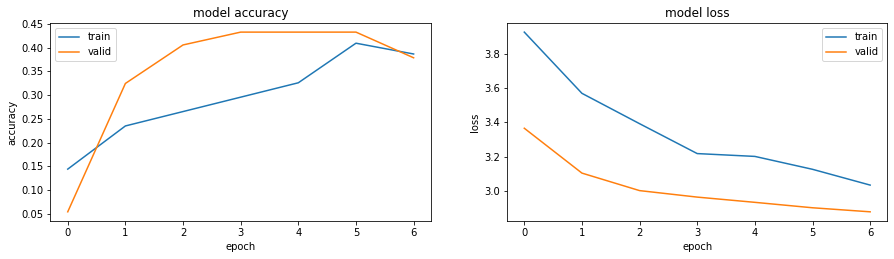


Hyperparameters: [[6.40e+01 1.00e-03 1.00e-01 1.00e+00 3.00e-01 1.28e+02]]
2/2 [==============================] - 0s 12ms/step - loss: 1.5749 - accuracy: 0.5405

Epoch 1: val_accuracy improved from -inf to 0.24324, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.24324 to 0.40541, saving model to VGG_16.h5

Epoch 3: val_accuracy did not improve from 0.40541

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 4: val_accuracy did not improve from 0.40541

Epoch 5: val_accuracy improved from 0.40541 to 0.45946, saving model to VGG_16.h5

Epoch 6: val_accuracy did not improve from 0.45946

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0003600000170990825.

Epoch 7: val_accuracy did not improve from 0.45946

Epoch 8: val_accuracy did not improve from 0.45946
Epoch 8: early stopping
2/2 [==============================] - 0s 7ms/step - loss: 12.5929 - accuracy: 0.2973

LOSS:	12.592910766601562 	 ACCURACY:	0.29729729890823364
[12.592910

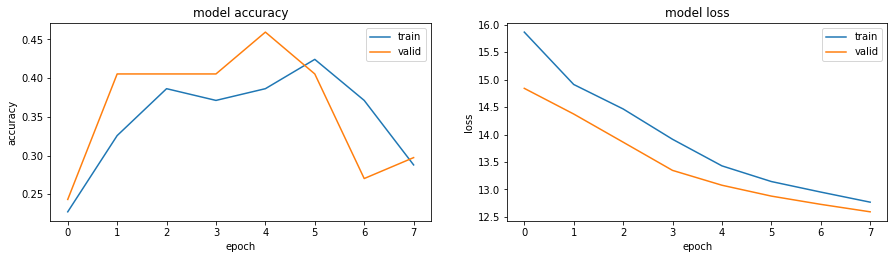


Hyperparameters: [[6.4e+01 1.0e-05 1.0e-02 2.0e+00 7.0e-01 3.2e+01]]
2/2 [==============================] - 0s 7ms/step - loss: 1.5749 - accuracy: 0.5405

Epoch 1: val_accuracy improved from -inf to 0.13514, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.13514

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 3: val_accuracy did not improve from 0.13514

Epoch 4: val_accuracy did not improve from 0.13514
Epoch 4: early stopping
2/2 [==============================] - 0s 6ms/step - loss: 4.2444 - accuracy: 0.1351

LOSS:	4.244350433349609 	 ACCURACY:	0.13513512909412384
[4.244350433349609, 0.13513512909412384]



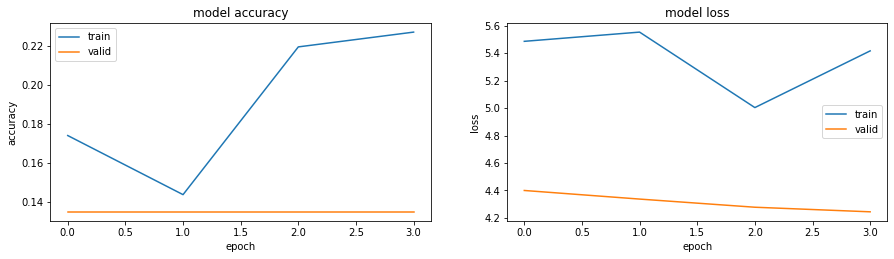


Hyperparameters: [[6.40e+01 1.00e-05 1.00e-01 2.00e+00 7.00e-01 2.56e+02]]
2/2 [==============================] - 0s 6ms/step - loss: 1.5749 - accuracy: 0.5405

Epoch 1: val_accuracy improved from -inf to 0.35135, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.35135

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 3: val_accuracy did not improve from 0.35135

Epoch 4: val_accuracy did not improve from 0.35135
Epoch 4: early stopping
2/2 [==============================] - 0s 6ms/step - loss: 15.5988 - accuracy: 0.3514

LOSS:	15.59875774383545 	 ACCURACY:	0.3513513505458832
[15.59875774383545, 0.3513513505458832]



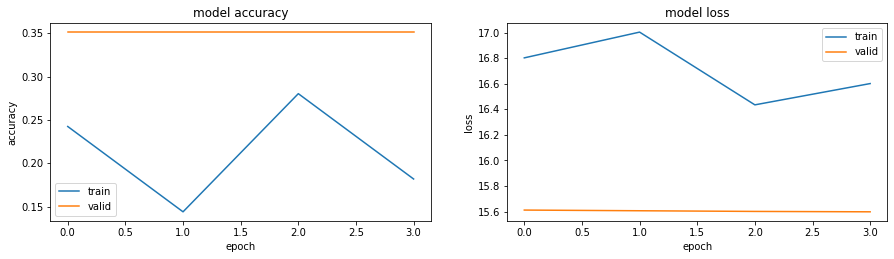


Hyperparameters: [[6.40e+01 1.00e-04 1.00e-03 2.00e+00 5.00e-01 2.56e+02]]
2/2 [==============================] - 0s 4ms/step - loss: 1.5749 - accuracy: 0.5405

Epoch 1: val_accuracy improved from -inf to 0.29730, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.29730

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 3: val_accuracy did not improve from 0.29730

Epoch 4: val_accuracy did not improve from 0.29730
Epoch 4: early stopping
2/2 [==============================] - 0s 8ms/step - loss: 1.7990 - accuracy: 0.2703

LOSS:	1.7989803552627563 	 ACCURACY:	0.2702702581882477
[1.7989803552627563, 0.2702702581882477]



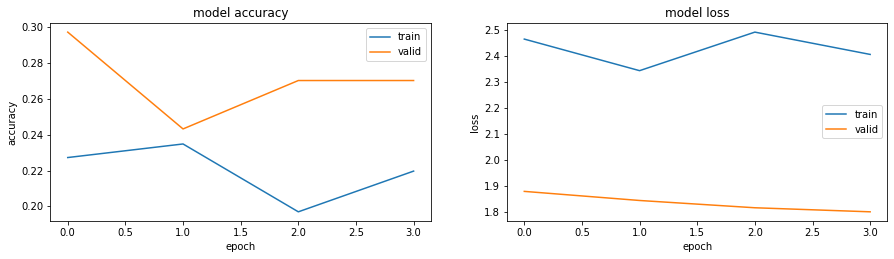


Hyperparameters: [[6.4e+01 1.0e-04 1.0e-02 1.0e+00 3.0e-01 3.2e+01]]
2/2 [==============================] - 0s 7ms/step - loss: 1.5749 - accuracy: 0.5405

Epoch 1: val_accuracy improved from -inf to 0.27027, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.27027 to 0.32432, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.32432 to 0.37838, saving model to VGG_16.h5

Epoch 4: val_accuracy did not improve from 0.37838

Epoch 5: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 5: val_accuracy did not improve from 0.37838

Epoch 6: val_accuracy did not improve from 0.37838
Epoch 6: early stopping
2/2 [==============================] - 0s 8ms/step - loss: 2.8595 - accuracy: 0.3784

LOSS:	2.8595283031463623 	 ACCURACY:	0.37837839126586914
[2.8595283031463623, 0.37837839126586914]



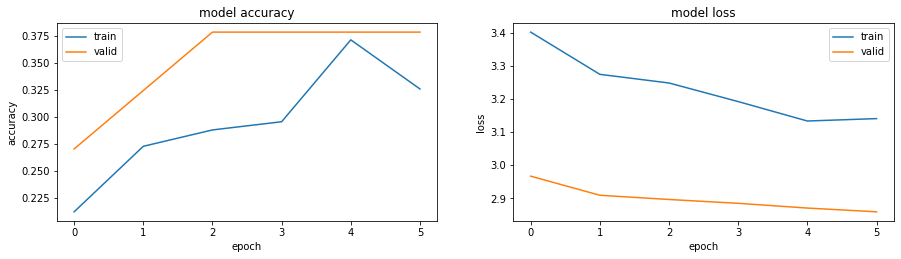


Hyperparameters: [[6.40e+01 1.00e-06 1.00e-02 2.00e+00 5.00e-01 1.28e+02]]
2/2 [==============================] - 0s 6ms/step - loss: 1.5749 - accuracy: 0.5405

Epoch 1: val_accuracy improved from -inf to 0.24324, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.24324

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 3: val_accuracy did not improve from 0.24324

Epoch 4: val_accuracy did not improve from 0.24324
Epoch 4: early stopping
2/2 [==============================] - 0s 6ms/step - loss: 3.6002 - accuracy: 0.2432

LOSS:	3.6001534461975098 	 ACCURACY:	0.2432432472705841
[3.6001534461975098, 0.2432432472705841]



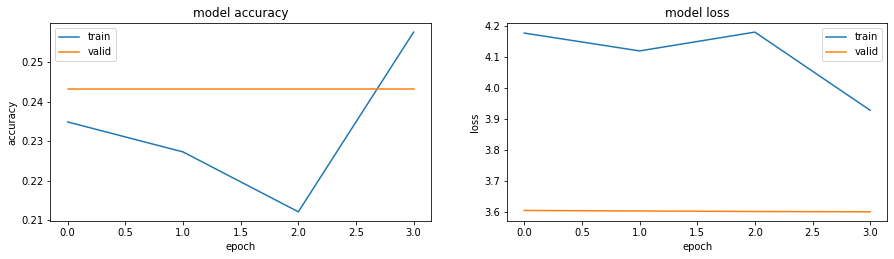


Hyperparameters: [[6.40e+01 1.00e-05 1.00e-03 1.00e+00 3.00e-01 1.28e+02]]
2/2 [==============================] - 0s 12ms/step - loss: 1.5749 - accuracy: 0.5405

Epoch 1: val_accuracy improved from -inf to 0.08108, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.08108

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 3: val_accuracy did not improve from 0.08108

Epoch 4: val_accuracy did not improve from 0.08108
Epoch 4: early stopping
2/2 [==============================] - 0s 8ms/step - loss: 3.2395 - accuracy: 0.0811

LOSS:	3.239532470703125 	 ACCURACY:	0.0810810774564743
[3.239532470703125, 0.0810810774564743]



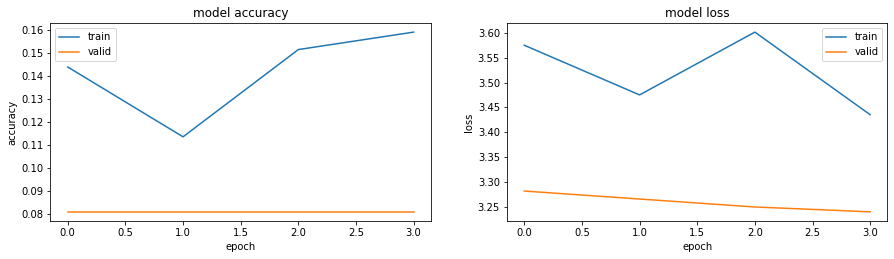


Hyperparameters: [[6.4e+01 1.0e-04 1.0e-03 1.0e+00 7.0e-01 3.2e+01]]
2/2 [==============================] - 0s 5ms/step - loss: 1.5749 - accuracy: 0.5405

Epoch 1: val_accuracy improved from -inf to 0.05405, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.05405 to 0.27027, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.27027 to 0.35135, saving model to VGG_16.h5

Epoch 4: val_accuracy did not improve from 0.35135

Epoch 5: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 5: val_accuracy did not improve from 0.35135

Epoch 6: val_accuracy did not improve from 0.35135
Epoch 6: early stopping
2/2 [==============================] - 0s 6ms/step - loss: 1.7319 - accuracy: 0.2973

LOSS:	1.7319245338439941 	 ACCURACY:	0.29729729890823364
[1.7319245338439941, 0.29729729890823364]



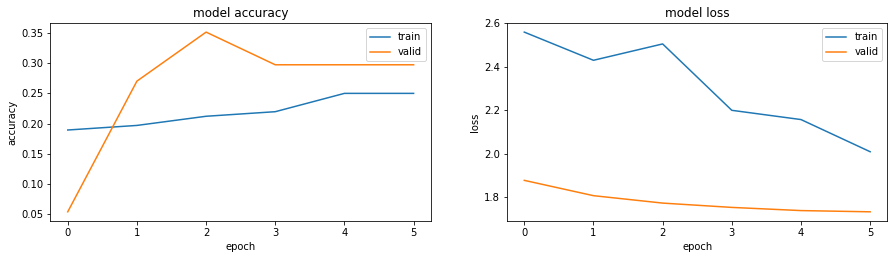


Hyperparameters: [[6.40e+01 1.00e-06 1.00e-02 1.00e+00 7.00e-01 1.28e+02]]
2/2 [==============================] - 0s 5ms/step - loss: 1.5749 - accuracy: 0.5405

Epoch 1: val_accuracy improved from -inf to 0.05405, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.05405

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 3: val_accuracy did not improve from 0.05405

Epoch 4: val_accuracy did not improve from 0.05405
Epoch 4: early stopping
2/2 [==============================] - 0s 9ms/step - loss: 3.3959 - accuracy: 0.0541

LOSS:	3.395862579345703 	 ACCURACY:	0.054054055362939835
[3.395862579345703, 0.054054055362939835]



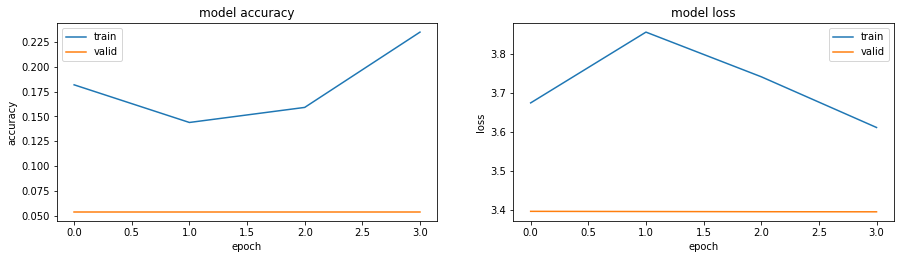


Hyperparameters: [[6.40e+01 1.00e-06 1.00e-01 3.00e+00 3.00e-01 1.28e+02]]
2/2 [==============================] - 0s 7ms/step - loss: 1.5749 - accuracy: 0.5405

Epoch 1: val_accuracy improved from -inf to 0.18919, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.18919

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 3: val_accuracy did not improve from 0.18919

Epoch 4: val_accuracy did not improve from 0.18919
Epoch 4: early stopping
2/2 [==============================] - 0s 6ms/step - loss: 15.7667 - accuracy: 0.1892

LOSS:	15.766743659973145 	 ACCURACY:	0.18918919563293457
[15.766743659973145, 0.18918919563293457]



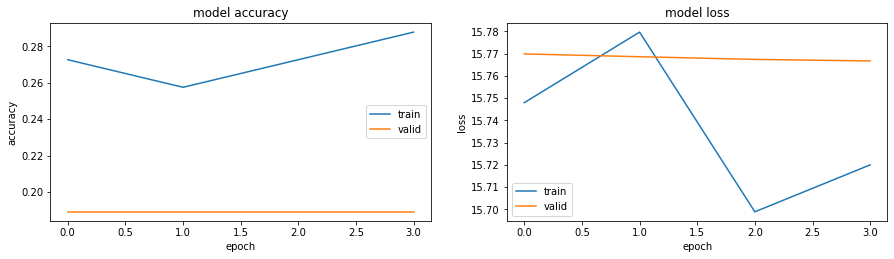


Hyperparameters: [[6.4e+01 1.0e-05 1.0e-01 1.0e+00 7.0e-01 3.2e+01]]
2/2 [==============================] - 0s 6ms/step - loss: 1.5749 - accuracy: 0.5405

Epoch 1: val_accuracy improved from -inf to 0.18919, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.18919

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 3: val_accuracy did not improve from 0.18919

Epoch 4: val_accuracy did not improve from 0.18919
Epoch 4: early stopping
2/2 [==============================] - 0s 6ms/step - loss: 16.0059 - accuracy: 0.1622

LOSS:	16.00592613220215 	 ACCURACY:	0.1621621549129486
[16.00592613220215, 0.1621621549129486]



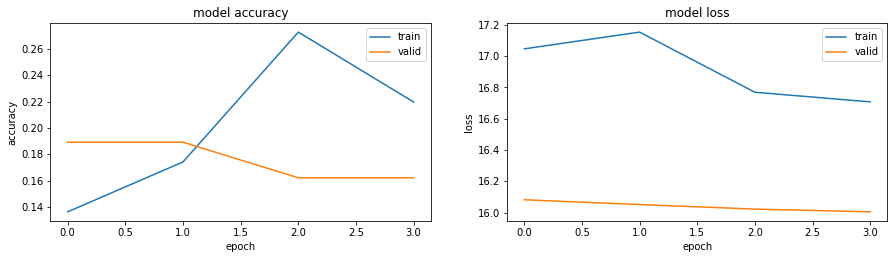


Hyperparameters: [[1.28e+02 1.00e-05 1.00e-02 3.00e+00 5.00e-01 2.56e+02]]
2/2 [==============================] - 0s 10ms/step - loss: 1.5749 - accuracy: 0.5405

Epoch 1: val_accuracy improved from -inf to 0.24324, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.24324

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 3: val_accuracy did not improve from 0.24324

Epoch 4: val_accuracy did not improve from 0.24324
Epoch 4: early stopping
2/2 [==============================] - 0s 6ms/step - loss: 5.1081 - accuracy: 0.2432

LOSS:	5.108142852783203 	 ACCURACY:	0.2432432472705841
[5.108142852783203, 0.2432432472705841]



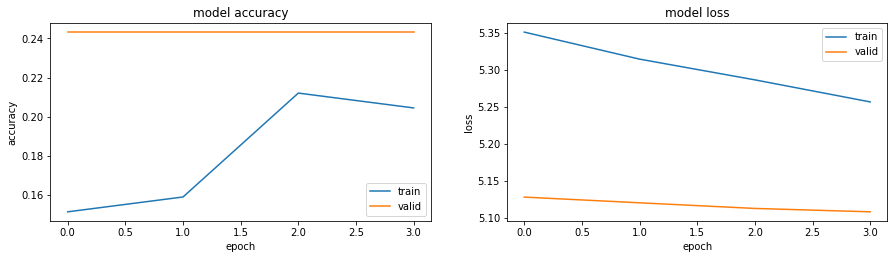

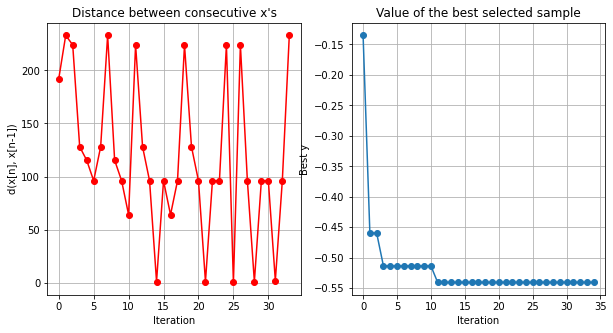

In [12]:
# define the kernel for the Bayesian surrogate model using the "radial basis function" (RBF)
kernel = GPy.kern.RBF(input_dim=1, variance=1.0, lengthscale=1.0)
# hyperparameter bounds
bounds = [{'name': 'units', 'type': 'discrete', 'domain': (64, 128, 256, 512)},
          {'name': 'learning_rate', 'type': 'discrete', 'domain': (1e-3, 1e-4, 1e-5, 1e-6)},
          {'name': 'l2', 'type': 'discrete', 'domain': (1e-1, 1e-2, 1e-3)},
          {'name': 'activation', 'type': 'discrete', 'domain': (1, 2, 3)},
          {'name': 'rate', 'type': 'discrete', 'domain': (0.3, 0.5, 0.7)},
          {'name': 'batch', 'type': 'discrete', 'domain': (32, 128, 256)}]
# Note: 'activation' domain parameters (1, 2, 3) correspond to strings ('relu', 'elu', 'tanh'); dictionary defined in build_model()
# objective function for the model optimization:
def f(x):
  """objective function of the Bayesian surrogate model"""
  print()
  print("Hyperparameters:", x)
  # Retrieve 'accuracy' from the previously saved model
  try:
    previous_best_model = K.models.load_model('VGG_16_best.h5')
    previous_evaluation = evaluate_model(previous_best_model)
  except Exception:
    previous_best_model = None
  model, lr_reduce, early_stop, checkpoint, batch = build_model(
                                        units=int(x[:,0]),
                                        learning_rate=float(x[:,1]),
                                        l2=float(x[:,2]),
                                        activation=int(x[:,3]),
                                        rate=float(x[:,4]),
                                        batch=int(x[:,5]))
  history = fit_model(model, lr_reduce, early_stop, checkpoint, batch)
  evaluation = evaluate_model(model)
  print()
  print("LOSS:\t{0} \t ACCURACY:\t{1}".format(evaluation[0],
  evaluation[1]))
  print(evaluation)
  print()
  # compare previous and current validation accuracies
  if not previous_best_model:
    K.models.save_model(model, 'VGG_16_best.h5', overwrite=False,
    include_optimizer=True)
  if previous_best_model and evaluation[1] > previous_evaluation[1]:
    K.models.save_model(model, 'VGG_16_best.h5', overwrite=True,
    include_optimizer=True)
  # Get the dictionary containing each metric and the loss for each epoch
  # history_dict = history.history
  # print(history_dict)
  def plot_history(history):
  #function that plots the model loss and accuracy
    plt.figure(1, figsize = (15,8))
    plt.subplot(221)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'])
    plt.subplot(222)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'])
    plt.show()
  # plot the model accuracy and loss results
  plot_history(history)
  # delete the instantiated models from memory and clear the session
  del model
  del previous_best_model
  K.backend.clear_session()
  return evaluation[1]
# Initializing X and Y, and adding noise (if need be)
# X_init = np.array([[int(16)]])
# Y_init = f(X_init)
# noise = 0.2
optimizer = BayesianOptimization(f=f,
                                 domain=bounds,
                                 model_type='GP',
                                 kernel=kernel,
                                 acquisition_type ='EI',
                                 acquisition_jitter = 0.01,
                                 # X=X_init,
                                 # Y=-Y_init,
                                 # noise_var = noise**2,
                                 exact_feval=False,
                                 normalize_Y=False,
                                 maximize=True,
                                 verbosity=False)
print()
print("=====================")
print("=====================")
print()
optimizer.run_optimization(max_iter=30, verbosity=False)
optimizer.plot_acquisition()
optimizer.plot_convergence()
optimizer.save_report('bayes_opt.txt')

In [13]:
# print optimized model
activation_dict = {1: 'relu', 2: 'elu', 3: 'tanh'}
print("""
Optimized Parameters:
\t{0}:\t{1}
\t{2}:\t{3}
\t{4}:\t{5}
\t{6}:\t{7}
\t{8}:\t{9}
""".format(bounds[0]["name"], optimizer.x_opt[0],
           bounds[1]["name"], optimizer.x_opt[1],
           bounds[2]["name"], optimizer.x_opt[2],
           bounds[3]["name"], activation_dict[optimizer.x_opt[3]],
           bounds[4]["name"], optimizer.x_opt[4],
           bounds[5]["name"], optimizer.x_opt[5]))
print("optimized accuracy: {0}".format(abs(optimizer.fx_opt)))


Optimized Parameters:
	units:	128.0
	learning_rate:	0.001
	l2:	0.001
	activation:	relu
	rate:	0.7

optimized accuracy: [0.54054052]


In [14]:
# reinstantiate the best model from saved file
best_model = K.models.load_model('VGG_16_best.h5')
best_model.summary()
loss, acc = best_model.evaluate(features_valid, y_test)
print('Restored model, accuracy: {:5.2f}%'.format(100*acc))

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 512)]             0         
                                                                 
 dense (Dense)               (None, 128)               65664     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                 645       
                                                                 
Total params: 66,309
Trainable params: 66,309
Non-trainable params: 0
_________________________________________________________________
2/2 [==============================] - 0s 8ms/step - loss: 1.5749 - accuracy: 0.5405
Restored model, accuracy: 54.05%


In [15]:
best_model.evaluate(features_valid, y_test)

2/2 [==============================] - 0s 10ms/step - loss: 1.5749 - accuracy: 0.5405


[1.5748697519302368, 0.5405405163764954]

In [16]:
data_path = 'bayes_opt.txt'
with open(data_path, 'r') as f:
  lines = f.read().split('\n')
for line in lines:
  print(line)

----------------------------- GPyOpt Report file -----------------------------------
GPyOpt Version 1.2.1
Date and time:               Thu May 26 22:03:34 2022
Optimization completed:      NO,35 samples collected.
Number initial samples:      5 
Tolerance:                   1e-08.
Optimization time:           75.63076400756836 seconds.

-------------------------------- Problem set up ------------------------------------
Problem name:                no_name
Problem dimension:           6
Number continuous variables  0
Number discrete variables    6
Number bandits               0
Noiseless evaluations:       False
Cost used:                   Used defined cost
Constrains:                  False

------------------------------ Optimization set up ---------------------------------
Normalized outputs:          False
Model type:                  GP
Model update interval:       1
Acquisition type:            EI
Acquisition optimizer:       lbfgs
Acquisition type:            EI
Acquisition opt

Test model with test data

In [17]:
#https://stackoverflow.com/questions/55674648/how-to-load-local-dataset-x-y-using-keras-framework
!pip install image-dataset-loader
from image_dataset_loader import load

(x_train, y_train), (x_test, y_test) = load('/content/output/', ['train', 'test'])

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [18]:
#  preprocess the data using the application's preprocess_input method and convert the labels to one-hot encodings
x_test, y_test = preprocess_data(x_test, y_test)

In [19]:

# repeat the same operation with the test data (here used for test)
test_datagen = K.preprocessing.image.ImageDataGenerator(rescale=1./255)  # no augmentation for test set
test_generator = test_datagen.flow(x_test,
                                 y_test,
                                 batch_size=32,
                                 shuffle=False)
features_test = base_model.predict(test_generator)

In [20]:
# reinstantiate the best model from saved file
loss, acc = best_model.evaluate(features_test, y_test)
print('Restored model, accuracy: {:5.2f}%'.format(100*acc))

1/1 [==============================] - 0s 33ms/step - loss: 1.6974 - accuracy: 0.3750
Restored model, accuracy: 37.50%


In [21]:
best_model.evaluate(features_test, y_test)

1/1 [==============================] - 0s 43ms/step - loss: 1.6974 - accuracy: 0.3750


[1.697374939918518, 0.375]